## Machine Learning Deployment for MNIST Dataset

### Import Libraries

In [1]:
!pip install onnx onnxruntime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import onnx
import onnxruntime as ort
import json
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Data Normalization

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load full MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 57.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.04MB/s]


### Split the Dataset

In [ ]:

train_size = int(2/3 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### CNN Model Definition

In [ ]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool_layer1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool_layer2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv_layer1(x))
        x = self.pool_layer1(x)
        x = torch.relu(self.conv_layer2(x))
        x = self.pool_layer2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Set Training Parameters

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Device: {device}")

model = MnistCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Device: cpu


### Scheduler Setup

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

### Train the Model

In [ ]:

epochs = 10

for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {training_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    scheduler.step(val_loss)

    print(f"Current Learning Rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

Epoch [1/10], Loss: 190.2330, Accuracy: 0.9061
Current Learning Rate: 0.010000
Epoch [2/10], Loss: 103.1466, Accuracy: 0.9516
Current Learning Rate: 0.010000
Epoch [3/10], Loss: 89.6029, Accuracy: 0.9582
Current Learning Rate: 0.010000
Epoch [4/10], Loss: 84.5722, Accuracy: 0.9597
Current Learning Rate: 0.005000
Epoch [5/10], Loss: 61.8390, Accuracy: 0.9718
Current Learning Rate: 0.005000
Epoch [6/10], Loss: 56.4756, Accuracy: 0.9724
Current Learning Rate: 0.005000
Epoch [7/10], Loss: 53.3668, Accuracy: 0.9732
Current Learning Rate: 0.005000
Epoch [8/10], Loss: 50.4471, Accuracy: 0.9747
Current Learning Rate: 0.005000
Epoch [9/10], Loss: 51.2906, Accuracy: 0.9751
Current Learning Rate: 0.002500
Epoch [10/10], Loss: 38.2436, Accuracy: 0.9808
Current Learning Rate: 0.002500


### Save the model as ONNX format

In [ ]:
onnx_model_path = "/content/drive/MyDrive/Spring 2025/Courses/CPE 590 - ML/Homeworks/HW05/mnist_cnn.onnx"
dummy_input = torch.randn(1, 1, 28, 28).to(device)

torch.onnx.export(
    model, dummy_input, onnx_model_path,
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print(f"Model exported as {onnx_model_path}")

Model exported as /content/drive/MyDrive/Spring 2025/Courses/CPE 590 - ML/Homeworks/HW05/mnist_cnn.onnx


### Save 5 Random Test Samples

In [ ]:
test_samples = random.sample(list(test_dataset), 5)
saved_examples = []

for idx, (image, label) in enumerate(test_samples):
    image_np = image.squeeze(0).numpy().tolist()
    saved_examples.append({
        "pixels": image_np,
        "label": int(label)
    })

# Save to JSON
with open("/content/drive/MyDrive/Spring 2025/Courses/CPE 590 - ML/Homeworks/HW05/sample_test_images.json", "w") as f:
    json.dump(saved_examples, f)

print("Saved 5 test samples to sample_test_images.json")


Saved 5 test samples to sample_test_images.json


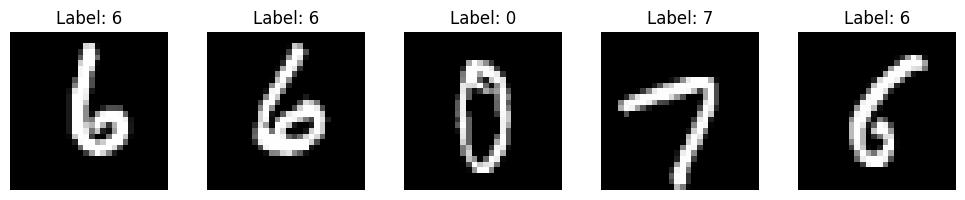

In [3]:
# Load the JSON file
with open("/content/drive/MyDrive/Spring 2025/Courses/CPE 590 - ML/Homeworks/HW05/sample_test_images.json", "r") as f:
    samples = json.load(f)

# Display the images
plt.figure(figsize=(10, 2))
for i, sample in enumerate(samples):
    pixels = np.array(sample["pixels"], dtype=np.float32)
    pixels = (pixels * 255).astype(np.uint8).reshape(28, 28)
    # pixels = np.array(sample["pixels"], dtype=np.uint8).reshape(28, 28)
    label = sample["label"]

    plt.subplot(1, 5, i + 1)
    plt.imshow(pixels, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Run Inference with ONNX


ONNX Prediction Accuracy on 5 Samples: 5/5


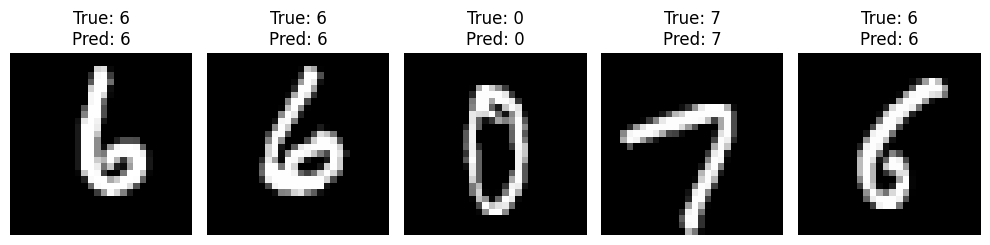

In [ ]:
import numpy as np
import onnxruntime as ort
import json
import matplotlib.pyplot as plt

# Load the ONNX model
ort_session = ort.InferenceSession(onnx_model_path)

# Load the test samples
json_path = "/content/drive/MyDrive/Spring 2025/Courses/CPE 590 - ML/Homeworks/HW05/sample_test_images.json"
with open(json_path, "r") as f:
    test_samples = json.load(f)

correct = 0
predictions = []

for i, sample in enumerate(test_samples):
    image_np = np.array(sample["pixels"], dtype=np.float32).reshape(1, 1, 28, 28)
    true_label = sample["label"]

    ort_inputs = {ort_session.get_inputs()[0].name: image_np}
    ort_outs = ort_session.run(None, ort_inputs)
    predicted_label = np.argmax(ort_outs[0], axis=1)[0]

    predictions.append((image_np.squeeze(), true_label, predicted_label))

    # print(f"Sample {i+1}: True Label = {true_label}, Predicted = {predicted_label}")
    if predicted_label == true_label:
        correct += 1

print(f"\nONNX Prediction Accuracy on 5 Samples: {correct}/5")

plt.figure(figsize=(10, 3))
for idx, (image, true_label, pred_label) in enumerate(predictions):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
